#Authors
**Author 1 (name and surname):** Sandra Burgos Artiguez

**Author 2 (name and surname):** Arántzazu López-Larraínzar Salazar

**Author 3 (name and surname):** Alan García Justel


# Exercise 1
As we have seen in the lab, we can train a ViT on small datasets and obtain reasonable performances. However, the training was a bit slow compared to our recent experiences with CNNs (>1 minute per epoch compared to about 20 seconds).

Do not panic, as usual, there is room for improvement if we modify the correct (hyper)parameters.

Implement your own modifications in the code to improve over the ViT baseline of lab 7. Play with the relevant hyperparameters or use any of the techniques learned in class to **improve the top-1 accuracy** of your test set. Document your experiments using a table like this:

<table>
  <tr>
    <th>ID</th>
    <th>Architecture</th>    
    <th>Image<br>size</br></th>
    <th>Patch<br>size</br></th>
    <th>Transformer<br>layers</br></th>
    <th>Projection<br>dim</br></th>
    <th>Epochs</th>
    <th>Batch<br>size</br></th>
    <th>Optimizer</th>
    <th>Learning<br>rate</br></th>
    <th>Lr scheduler</th>
    <th>Val acc</th>
    <th>Test acc</th>
    <th>Time per<br>epoch<br></th>
    <th>Data<br>augmentation</br></th>
  </tr>
  <tr>
    <td>0</td>
    <td>vanilla ViT</td>    
    <td>72</td>
    <td>6</td>
    <td>8</td>
    <td>64</td>
    <td>25</td>
    <td>256</td>
    <td>AdamW</td>
    <td>0.001</td>
    <td>None</td>
    <td>76.93%</td>
    <td>75.92%</td>
    <td>~60s</td>
    <td>Horizontal flip</td>
  </tr>
  <tr>
    <td>1</td>
    <td>ViT_sl</td>    
    <td>72</td>
    <td>6</td>
    <td>8</td>
    <td>64</td>
    <td>25</td>
    <td>256</td>
    <td>AdamW</td>
    <td>0.001</td>
    <td>None</td>
    <td>77.69%</td>
    <td>77.58%</td>
    <td>~72s</td>
    <td>Horizontal flip</td>
  </tr>  
</table>


**HINTS**: In the lab, we used an input image size (72x72) which is much larger than the actual size of the images in CIFAR10 (32x32). This can be adjusted to speed up the process. Also, the number of transformer layers (8) makes the number of parameters of the model quite high and could be reduced.

**NOTE**: With some modifications, a top-1 accuracy of about 82% is achievable in the test set.

## Set up

In [ ]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers
import itertools
import random


# Set seed for experiment reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

## Prepare the data

In [ ]:
NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [ ]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
IMAGE_SIZE = [72, 86, 100, 120]
PATCH_SIZE = [4, 6, 8]
NUM_PATCHES = [((image_size // patch_size) ** 2) for image_size in IMAGE_SIZE for patch_size in PATCH_SIZE]

# OPTIMIZER

# TRAINING
EPOCHS = 25

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
] # Size of the transformer layers
MLP_HEAD_UNITS = [2048, 1024] # Size of the dense layers of the final classifier

## Use data augmentation

In [ ]:
# IMAGE_SIZE es ahora un hyperparametro
def data_augmentation(IMAGE_SIZE):
    data_augmentation = tf.keras.Sequential(
        [
            layers.Normalization(),
            layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Redimensionamos con el valor actual de IMAGE_SIZE
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(factor=0.02),
            layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        ],
        name="data_augmentation",
    )
    data_augmentation.layers[0].adapt(x_train)
    return data_augmentation

## Shifted Patch Tokenization

In [ ]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size = 100,
        patch_size = 6,
        num_patches = 4,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

## Implement de patch encoding layer

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches


## Implement Locality Self Attention

In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

## Implement the MLP

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x



## Implement the MLP


In [ ]:
def create_vit_classifier(image_size, patch_size, num_patches, transformers_layers, vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(image_size)(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(image_size, patch_size, num_patches,vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches)(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(transformers_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            # Build the diagonal attention mask
            diag_attn_mask = 1 - tf.eye(num_patches)
            diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Compile, train and evaluate the model

In [ ]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


## Run experiments

In [ ]:
def run_experiment(model, learning_rate, weight_decay, warmup=False):
    """Main method to run ViT training and testing

    Parameters
    ----------
    model : Keras model
        Input model (vanilla ViT or modified ViT)
    warmup : boolean, optional
        Set to True to use warmp-up cosine decay scheduler

    Returns
    -------
    history : History object
        record of training loss values and metrics values at successive epochs,
        as well as validation loss values and validation metrics values (if applicable).
    """

    # Warm-up parameters
    total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=learning_rate,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    # Learning rate scheduler
    lr = scheduled_lrs if warmup else learning_rate
    # Optimizer
    optimizer = keras.optimizers.AdamW(
        learning_rate=lr, weight_decay=weight_decay
    )

    # Model compilation
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Save best checkpoint only
    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )

    # Training
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.2,
        callbacks=[checkpoint_callback],
    )

    # Test
    model.load_weights(checkpoint_filepath)

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
# Definir los hiperparámetros
IMAGE_SIZE = [32, 64]
PATCH_SIZE = [4, 6]
LEARNING_RATE = [0.0001, 0.001, 0.01]
WEIGHT_DECAY = [0.0001, 0.001]
TRANSFORMER_LAYERS = [4, 6]


In [ ]:
# IMAGE_SIZE, PATCH_SIZE, LEARNING_RATE, WEIGHT_DECAY, TRANSFORMER_LAYERS
combinations = [(64, 6, 0.001, 0.0001, 4),
                (64, 4, 0.001, 0.0001, 6),
                (32, 4, 0.001, 0.0001, 6),
                (32, 4, 0.001, 0.0001, 6)]

In [ ]:
histories = []
vits = []
for combo in combinations:
    IMAGE_SIZE, PATCH_SIZE, LEARNING_RATE, WEIGHT_DECAY, TRANSFORMER_LAYERS = combo
    NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

    vit = create_vit_classifier(IMAGE_SIZE, PATCH_SIZE, NUM_PATCHES, TRANSFORMER_LAYERS, vanilla=True)
    vits.append(vit)
    history = run_experiment(vit, LEARNING_RATE, WEIGHT_DECAY,  warmup=False)
    histories.append(history)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'shifted_patch_tokenization', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2508 - loss: 2.6611 - top-5-accuracy: 0.7362
Epoch 1: val_accuracy improved from -inf to 0.45270, saving model to /tmp/checkpoint.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.2511 - loss: 2.6573 - top-5-accuracy: 0.7366 - val_accuracy: 0.4527 - val_loss: 1.5363 - val_top-5-accuracy: 0.9071
Epoch 2/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4036 - loss: 1.6526 - top-5-accuracy: 0.8798
Epoch 2: val_accuracy improved from 0.45270 to 0.50530, saving model to /tmp/checkpoint.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.4037 - loss: 1.6523 - top-5-accuracy: 0.8799 - val_accuracy: 0.5053 - val_loss: 1.3613 - val_top-5-accuracy: 0.9324
Epoch 3/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4666 - loss: 1.4888 - top-5-accuracy: 0.9121
Epoch 3: val_accuracy improved from 0.50530 to 0.55490, saving model to /tmp/checkpoint.weights.h5
157/157 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'shifted_patch_tokenization_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2301 - loss: 3.3498 - top-5-accuracy: 0.7167
Epoch 1: val_accuracy improved from -inf to 0.43850, saving model to /tmp/checkpoint.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 139ms/step - accuracy: 0.2304 - loss: 3.3432 - top-5-accuracy: 0.7171 - val_accuracy: 0.4385 - val_loss: 1.6237 - val_top-5-accuracy: 0.8887
Epoch 2/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.3838 - loss: 1.7001 - top-5-accuracy: 0.8675
Epoch 2: val_accuracy improved from 0.43850 to 0.49010, saving model to /tmp/checkpoint.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.3839 - loss: 1.6997 - top-5-accuracy: 0.8676 - val_accuracy: 0.4901 - val_loss: 1.3892 - val_top-5-accuracy: 0.9267
Epoch 3/25
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4527 - loss: 1.5123 - top-5-accuracy: 0.9119
Epoch 3: val_accuracy improved from 0.49010 to 0.53960, saving model to /tmp/checkpoint.weights.h5
157/157 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'shifted_patch_tokenization_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2532 - loss: 2.4994 - top-5-accuracy: 0.7418
Epoch 1: val_accuracy improved from -inf to 0.42970, saving model to /tmp/checkpoint.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 55ms/step - accuracy: 0.2535 - loss: 2.4964 - top-5-accuracy: 0.7422 - val_accuracy: 0.4297 - val_loss: 1.5794 - val_top-5-accuracy: 0.8935
Epoch 2/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4088 - loss: 1.6438 - top-5-accuracy: 0.8835
Epoch 2: val_accuracy improved from 0.42970 to 0.49640, saving model to /tmp/checkpoint.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4089 - loss: 1.6435 - top-5-accuracy: 0.8836 - val_accuracy: 0.4964 - val_loss: 1.4009 - val_top-5-accuracy: 0.9245
Epoch 3/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4563 - loss: 1.5078 - top-5-accuracy: 0.9109
Epoch 3: val_accuracy improved from 0.49640 to 0.52860, saving model to /tmp/checkpoint.weights.h5
157/157 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'shifted_patch_tokenization_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2456 - loss: 2.4598 - top-5-accuracy: 0.7336
Epoch 1: val_accuracy improved from -inf to 0.41700, saving model to /tmp/checkpoint.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 59ms/step - accuracy: 0.2459 - loss: 2.4571 - top-5-accuracy: 0.7340 - val_accuracy: 0.4170 - val_loss: 1.6130 - val_top-5-accuracy: 0.8907
Epoch 2/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3954 - loss: 1.6700 - top-5-accuracy: 0.8766
Epoch 2: val_accuracy improved from 0.41700 to 0.48280, saving model to /tmp/checkpoint.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3956 - loss: 1.6697 - top-5-accuracy: 0.8766 - val_accuracy: 0.4828 - val_loss: 1.4201 - val_top-5-accuracy: 0.9230
Epoch 3/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4585 - loss: 1.5027 - top-5-accuracy: 0.9093
Epoch 3: val_accuracy improved from 0.48280 to 0.53640, saving model to /tmp/checkpoint.weights.h5
157/157 ━━━━━━━━━━━━━━━━━

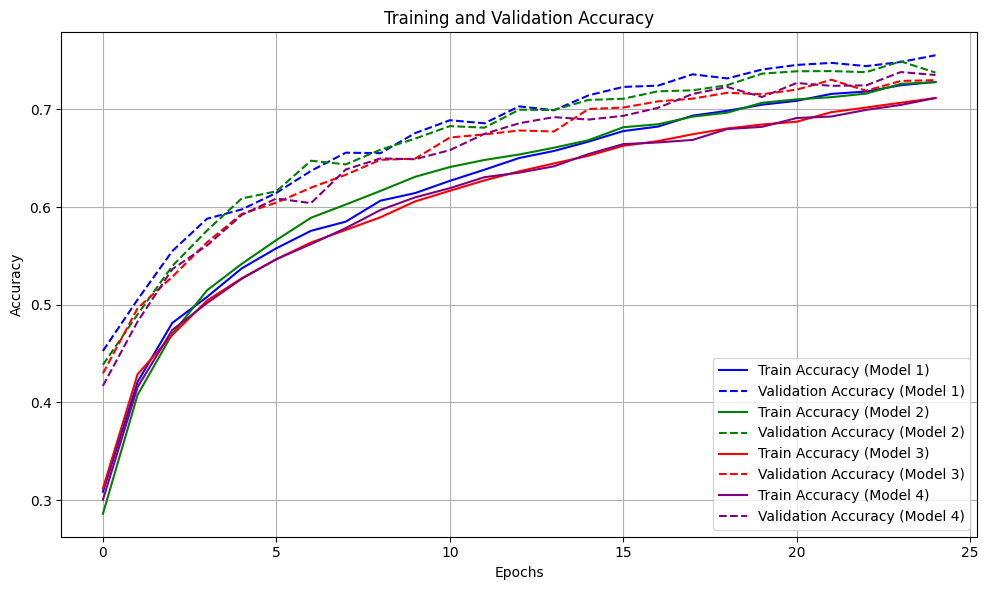

In [ ]:
import matplotlib.pyplot as plt

# Graficar precisión para cada modelo entrenado
plt.figure(figsize=(10, 6))

colors = ['blue', 'green', 'red', 'purple', 'orange']  # Añade más colores si tienes más modelos


for i, history in enumerate(histories):
      plt.plot(history.history['accuracy'], label=f'Train Accuracy (Model {i+1})', color=colors[i])
      plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy (Model {i+1})', color=colors[i], linestyle='--')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
# Lista para almacenar las precisiones en el conjunto de prueba
test_accuracies = []

# Evaluar el test accuracy de cada modelo
for i, model in enumerate(vits):  # Asumiendo que vits es la lista con tus modelos
    results = model.evaluate(x_test, y_test, verbose=0)  # Obtiene todas las métricas configuradas
    # Supongamos que la precisión es la segunda métrica, entonces:
    accuracy = results[1]  # El valor de la precisión estará en el índice 1
    test_accuracies.append(accuracy)  # Guardar el test accuracy en la lista

# Imprimir los resultados
for i, accuracy in enumerate(test_accuracies):
    print(f"Test Accuracy for Model {i+1}: {accuracy:.4f}")



Test Accuracy for Model 1: 0.7564
Test Accuracy for Model 2: 0.7440
Test Accuracy for Model 3: 0.7223
Test Accuracy for Model 4: 0.7249


<table>
  <tr>
    <th>ID</th>
    <th>Architecture</th>    
    <th>Image<br>size</br></th>
    <th>Patch<br>size</br></th>
    <th>Transformer<br>layers</br></th>
    <th>Projection<br>dim</br></th>
    <th>Epochs</th>
    <th>Batch<br>size</br></th>
    <th>Optimizer</th>
    <th>Learning<br>rate</br></th>
    <th>Weight<br>Decay</br></th>
    <th>Lr scheduler</th>
    <th>Val acc</th>
    <th>Test acc</th>
    <th>Time per<br>epoch<br></th>
    <th>Data<br>augmentation</br></th>
  </tr>
  <tr>
    <td>0</td>
    <td>vanilla ViT</td>    
    <td>72</td>
    <td>6</td>
    <td>8</td>
    <td>64</td>
    <td>25</td>
    <td>256</td>
    <td>AdamW</td>
    <td>0.001</td>
    <td>0.0001</td>
    <td>None</td>
    <td>76.93%</td>
    <td>75.92%</td>
    <td>60s</td>
    <td>Horizontal flip</td>
  </tr>
    <tr>
    <td>1</td>
    <td>ViT_sl</td>    
    <td>72</td>
    <td>6</td>
    <td>8</td>
    <td>64</td>
    <td>25</td>
    <td>256</td>
    <td>AdamW</td>
    <td>0.001</td>
    <td>0.0001</td>
    <td>None</td>
    <td>77.69%</td>
    <td>77.58%</td>
    <td>72s</td>
    <td>Horizontal flip</td>
   </tr>
  <tr>
    <td>1</td>
    <td>vanilla ViT_2</td>    
    <td>64</td>
    <td>6</td>
    <td>4</td>
    <td>64</td>
    <td>25</td>
    <td>256</td>
    <td>AdamW</td>
    <td>0.001</td>
    <td>0.0001</td>
    <td>None</td>
    <td>77.69%</td>
    <td>75.65%</td>
    <td>7s</td>
    <td>Horizontal flip, Random rotation, Random zoom</td>
   </tr>
    <tr>
    <td>2</td>
    <td>vanilla ViT_3</td>    
    <td>64</td>
    <td>4</td>
    <td>6</td>
    <td>64</td>
    <td>25</td>
    <td>256</td>
    <td>AdamW</td>
    <td>0.001</td>
    <td>0.0001</td>
    <td>None</td>
    <td>75.25%</td>
    <td>74.4%</td>
    <td>20s</td>
    <td>Horizontal flip, Random rotation, Random zoom</td>
  </tr>  
  <tr>
    <td>3</td>
    <td>vanilla ViT_4</td>    
    <td>32</td>
    <td>4</td>
    <td>6</td>
    <td>64</td>
    <td>25</td>
    <td>256</td>
    <td>AdamW</td>
    <td>0.001</td>
    <td>0.001</td>
    <td>None</td>
    <td>73.51</td>
    <td>72.23%</td>
    <td>7s</td>
    <td>Horizontal flip, Random rotation, Random zoom</td>
  <tr>
    <td>3</td>
    <td>vanilla ViT_5</td>    
    <td>32</td>
    <td>4</td>
    <td>6</td>
    <td>64</td>
    <td>25</td>
    <td>256</td>
    <td>AdamW</td>
    <td>0.001</td>
    <td>0.001</td>
    <td>None</td>
    <td>73.51</td>
    <td>72.48%</td>
    <td>6ss</td>
    <td>Horizontal flip, Random rotation, Random zoom</td>


</table>

In [ ]:
# Experiments on vanilla = false with the best configuration

IMAGE_SIZE, PATCH_SIZE, LEARNING_RATE, WEIGHT_DECAY, TRANSFORMER_LAYERS = (64,6,0.001, 0.0001, 4)
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

vit2 = create_vit_classifier(IMAGE_SIZE, PATCH_SIZE, NUM_PATCHES, TRANSFORMER_LAYERS, vanilla=False)
history2 = run_experiment(vit, LEARNING_RATE, WEIGHT_DECAY,  warmup=False)


Epoch 1/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2571 - loss: 2.5985 - top-5-accuracy: 0.7416
Epoch 1: val_accuracy improved from -inf to 0.43100, saving model to /tmp/checkpoint.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.2575 - loss: 2.5950 - top-5-accuracy: 0.7421 - val_accuracy: 0.4310 - val_loss: 1.5816 - val_top-5-accuracy: 0.8951
Epoch 2/25
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3922 - loss: 1.6744 - top-5-accuracy: 0.8740
Epoch 2: val_accuracy improved from 0.43100 to 0.49930, saving model to /tmp/checkpoint.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.3924 - loss: 1.6738 - top-5-accuracy: 0.8741 - val_accuracy: 0.4993 - val_loss: 1.4048 - val_top-5-accuracy: 0.9241
Epoch 3/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4485 - loss: 1.5304 - top-5-accuracy: 0.9054
Epoch 3: val_accuracy improved from 0.49930 to 0.54840, saving model to /tmp/checkpoint.weights.h5
157/157 ━━━━━━━━━━━━━━━━━

# Exercise 2
Comment on your results.

**Q2.1: What modifications have been more important to achieve better performance?**

The best results were achieved when we reduced the image size while keeping the patch size unchanged. This modification resulted in improved computational efficiency, but unfortunately, it did not lead to an increase in accuracy. Notice that in the data aumentation we have also included rotation and zoom.

**Q2.2: Using your best configuration, which of the two proposed models (vanilla or sl) worked better?**

With our best configuration, the model worked better was sI, with an accuracy of 76.18% over 75.65%.

# Egela submission
Copy this notebook to your Drive and solve the proposed exercises there.

Rename the notebook as `assignment-7-name1-surname1-name2-surname2.ipynb` (replace *name1-surname1* and *name2-surname2* with team member names and surnames).

Use the "share" button and make sure you configure such that "Anyone on the Internet with this link can view".

Copy the link provided by the "share" menu and paste it here. Only one member of the team should submit the notebook

<font color=red>**Important**</font>: Make sure the notebook is fully run when you deliver and the "traces" are visible (run times).

**Submission deadline**: Sunday, February 11th 2024, 23:59h.